In [1]:
# Importing libraries

import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
import numpy as np
import torchvision 
import random,math
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from operator import attrgetter
from functools import partial
from torch.utils.data import DataLoader,default_collate,Dataset
from copy import copy
from torch.optim.lr_scheduler import ExponentialLR
from collections.abc import Mapping
from diffusers import UNet2DModel
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
from diffusers import DDIMScheduler, DDPMScheduler,AutoencoderKL, UNet2DModel

2023-07-04 16:05:29.328195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 16:05:30.778190: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-04 16:05:30.778241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-04 16:05:30.778246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# Get the device
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {def_device}')

# Function to send data to device
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

Using device: cpu


In [3]:
from datasets import load_dataset

dataset = load_dataset("tglcourse/lsun_church_train")

Found cached dataset parquet (/home/shubham/.cache/huggingface/datasets/tglcourse___parquet/tglcourse--lsun_church_train-3bdaa15e015782f6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
train_ds = dataset['train']
valid_ds = dataset['test']

dataset = torch.utils.data.ConcatDataset([train_ds, valid_ds])

In [5]:
class LSUN_Dataset(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img = self.ds[idx]['image']
        label = self.ds[idx]['label']
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [6]:
transforms = T.Compose([T.ToTensor(),T.Resize((256,256),antialias=True)])

ds = LSUN_Dataset(dataset, transform=transforms)

In [7]:
batch_size = 32

train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)

torch.Size([32, 3, 256, 256])


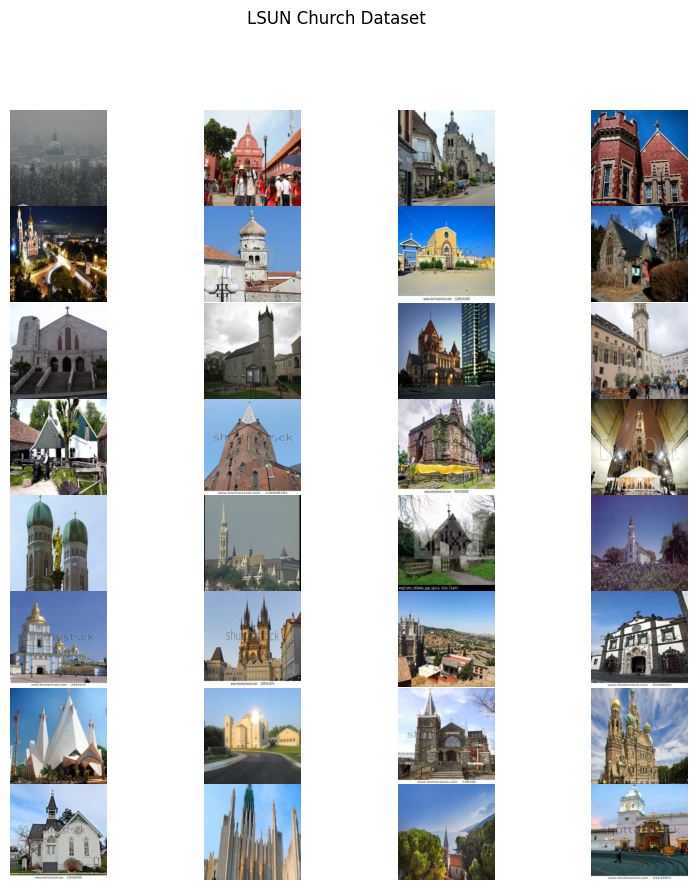

In [10]:
batch = next(iter(train_dl))

images = batch[0]
print(images.shape)

fig, ax = plt.subplots(8,4,figsize=(10,10),gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(8):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j].clamp(0,1).permute(1,2,0))
        ax[i,j].axis('off')
plt.suptitle('LSUN Church Dataset')
plt.show()

In [11]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(def_device).requires_grad_(False)

In [12]:
encoded_batch = vae.encode(images.to(def_device)).latent_dist.mean

torch.Size([32, 4, 32, 32])


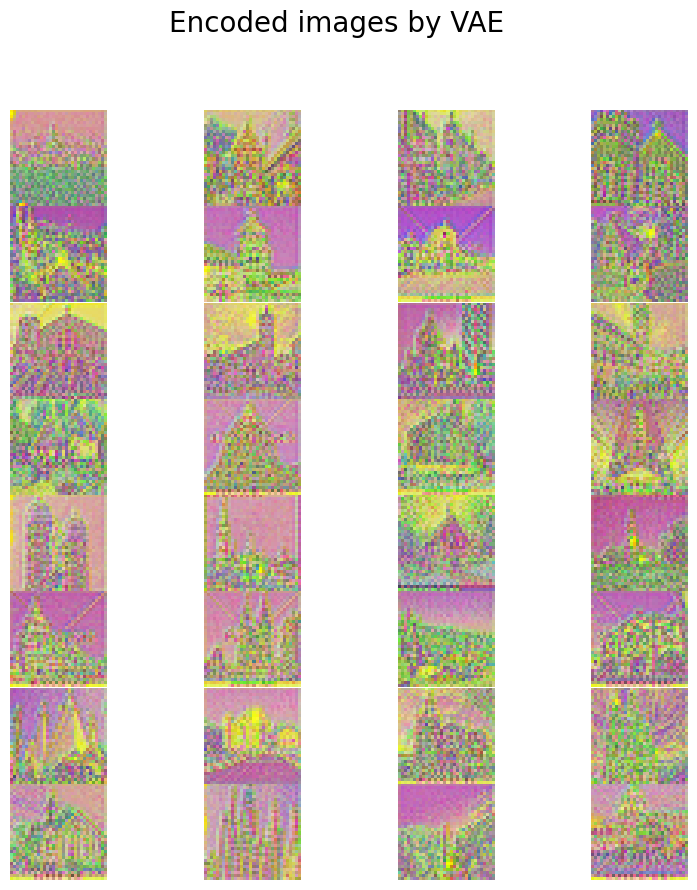

In [13]:
print(encoded_batch.shape)

fig, ax = plt.subplots(8,4,figsize=(10,10),gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(8):
    for j in range(4):
        ax[i,j].imshow((encoded_batch[i*4+j][:3]*0.18125).sigmoid().permute(1,2,0).cpu(),cmap='gray')
        ax[i,j].axis('off')
plt.suptitle('Encoded images by VAE',fontsize=20)
plt.show()

In [14]:
decoded_batch = vae.decode(encoded_batch)['sample']

torch.Size([32, 3, 256, 256])


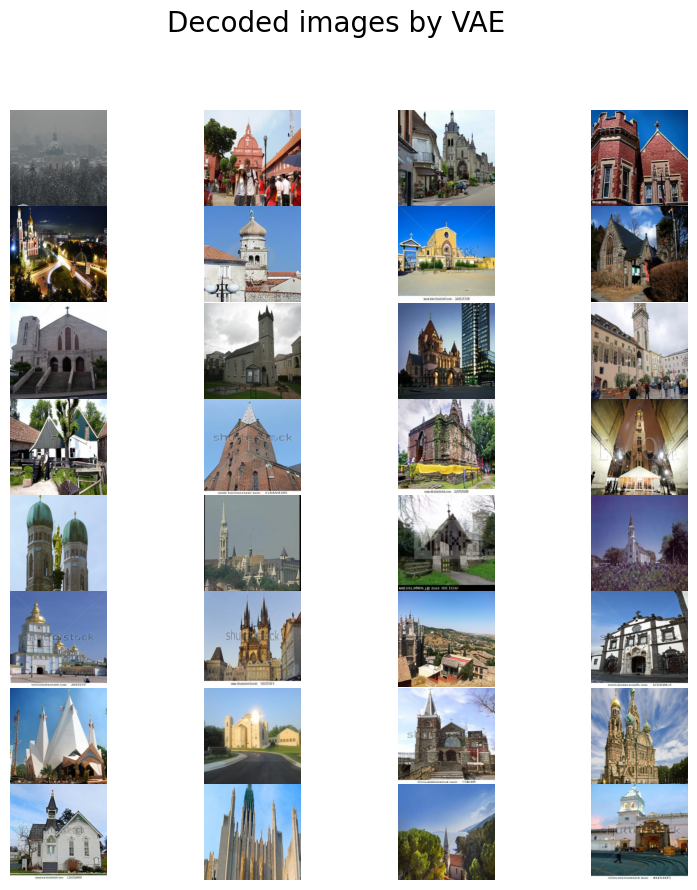

In [15]:
print(decoded_batch.shape)

fig, ax = plt.subplots(8,4,figsize=(10,10),gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(8):
    for j in range(4):
        ax[i,j].imshow(decoded_batch[i*4+j].clamp(0,1).permute(1,2,0).cpu(),cmap='gray')
        ax[i,j].axis('off')
plt.suptitle('Decoded images by VAE',fontsize=20)
plt.show()

In [ ]:
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'latents.dat')

In [28]:
len(train_dl)*32

126240

In [ ]:
mmshape = (len(train_dl)*32,4,32,32)

In [15]:
a = np.memmap(filename, np.float32, mode='w+', shape=mmshape)
i = 0
for b in tqdm(train_dl):
    images, labels = b
    n = len(images)
    a[i:i+n] = to_cpu((vae.encode(images.cuda()).latent_dist.sample().detach())*0.18125).numpy()
    i += n
a.flush()
del(a)

In [ ]:
latents = np.memmap(filename, dtype=np.float32, mode='r', shape=mmshape)

In [17]:
batch_size = 32
train_dl = DataLoader(latents, batch_size=batch_size, shuffle=True, num_workers=2)

In [18]:
class TimeEmbedding(nn.Module):

    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = nn.SiLU()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)
        return emb

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, emb_channels,dropout = 0.1):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        self.time_emb = nn.Linear(emb_channels, out_channels)
        self.time_act = nn.SiLU()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, t):
        h = self.conv1(self.act1(self.norm1(x)))
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))
        return h + self.shortcut(x)

In [20]:
class AttentionBlock(nn.Module):
    def __init__(self, n_channels, n_heads = 1, d_k= None):
        super().__init__()
        if d_k is None:
            d_k = n_channels
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output = nn.Linear(n_heads * d_k, n_channels)
        self.scale = d_k ** -0.5
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x, t = None):
        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=2)
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)
        res += x
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)
        return res


In [21]:
class DownBlock(nn.Module):
    def __init__(self, in_channels,out_channels, time_channels, has_attn):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x

In [22]:
class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x

In [23]:
class MiddleBlock(nn.Module):
    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x, t):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x

In [24]:
class Upsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x, t):
        return self.conv(x)


class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x, t):
        return self.conv(x)


In [25]:
class UNet(nn.Module):
    def __init__(self, image_channels= 3, n_channels=64,
                 ch_mults = (1, 2, 2, 4),
                 is_attn = (False, False, True, True),
                 n_blocks: int = 2):
        super().__init__()
        n_resolutions = len(ch_mults)
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))
        self.time_emb = TimeEmbedding(n_channels * 4)
        down = []
        out_channels = in_channels = n_channels
        for i in range(n_resolutions):
            out_channels = in_channels * ch_mults[i]
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        self.down = nn.ModuleList(down)

        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        up = []
        in_channels = out_channels
        for i in reversed(range(n_resolutions)):
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            if i > 0:
                up.append(Upsample(in_channels))

        self.up = nn.ModuleList(up)

        self.norm = nn.GroupNorm(8, n_channels)
        self.act = nn.SiLU()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x, t):
        t = self.time_emb(t)
        x = self.image_proj(x)
        h = [x]
        for m in self.down:
            x = m(x, t)
            h.append(x)

        x = self.middle(x, t)

        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                x = m(x, t)

        return self.final(self.act(self.norm(x)))

In [3]:
class DDPM_model(nn.Module):
    def __init__(self, model,beta_min = 0.00085, beta_max = 0.012, n_steps = 1000):
        super().__init__()
        self.model = model
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.n_steps = n_steps
        self.beta = torch.linspace(beta_min, beta_max, self.n_steps)
        self.alpha = 1. - self.beta
        self.alphabar = self.alpha.cumprod(dim=0)
        self.sigma = self.beta.sqrt()

    def add_noise(self, x_0):
        device = x_0.device
        n = len(x_0)
        timesteps = torch.randint(0, self.n_steps, (n,), device=device)
        alphabar_t = self.alphabar.to(device)[timesteps].reshape(-1, 1, 1, 1)
        noise = torch.randn_like(x_0, device=device)
        x_t = x_0 * alphabar_t.sqrt() + (1. - alphabar_t).sqrt()* noise
        return (x_t, timesteps.to(device)), noise

    def forward(self, x):
        return self.model.forward(*x).sample

In [5]:
unet_model = UNet2DModel(in_channels=4, out_channels=4,block_out_channels=(128,256,384,512))
model = DDPM_model(unet_model)

In [ ]:
epochs = 25
lr = 0.005
opt = optim.Adam(model.parameters(), lr=lr,eps = 1e-5)
sched = optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epochs, steps_per_epoch=len(train_dl))

In [29]:
def fit(model,train_dl,loss_func,epochs,opt,sched):
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(epochs):
        losses = []
        model.train()
        for xb,_ in train_dl:
            opt.zero_grad()
            xb = to_device(xb)
            (x_t, timesteps), noise = model.add_noise(xb)
            (x_t, timesteps) = to_device((x_t, timesteps))
            noise = to_device(noise)
            with torch.cuda.amp.autocast(dtype=torch.float16):
                preds = model((x_t, timesteps))
                loss = loss_func(preds, noise)
            losses.append(loss.item() * len(xb))
            scaler.scale(loss).backward()
            scaler.step(opt)
            sched.step()
            scaler.update()
        print(f"Epoch {epoch} train loss: {sum(losses)/len(train_ds)}")

In [30]:
fit(model.to(def_device),train_dl,F.mse_loss,epochs,opt,sched)

In [ ]:
model = model.cpu()
torch.save(model,"latent_diffusion.pt")
torch.save(model.state_dict(),"latent_diffusion_state_dict.pth")
torch.save(model.model.state_dict(),"latent_diffusion_unet_state_dict.pth")

In [8]:
model = DDPM_model(unet_model)
model.load_state_dict(torch.load("latent_diffusion_state_dict.pth",map_location=torch.device('cpu')))
model = model.to(def_device).eval()
vae = vae.to('cpu')

In [9]:
def sample(sched,model,sz = (16,4,32,32)):
    preds = []
    device = next(model.parameters()).device
    x_t = torch.randn(sz).to(device)
    for t in tqdm(sched.timesteps,total=sched.num_inference_steps):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        with torch.no_grad(): noise = model((x_t, t_batch))
        x_t = sched.step(noise, t, x_t).prev_sample
        preds.append(x_t.float().cpu())
    return preds

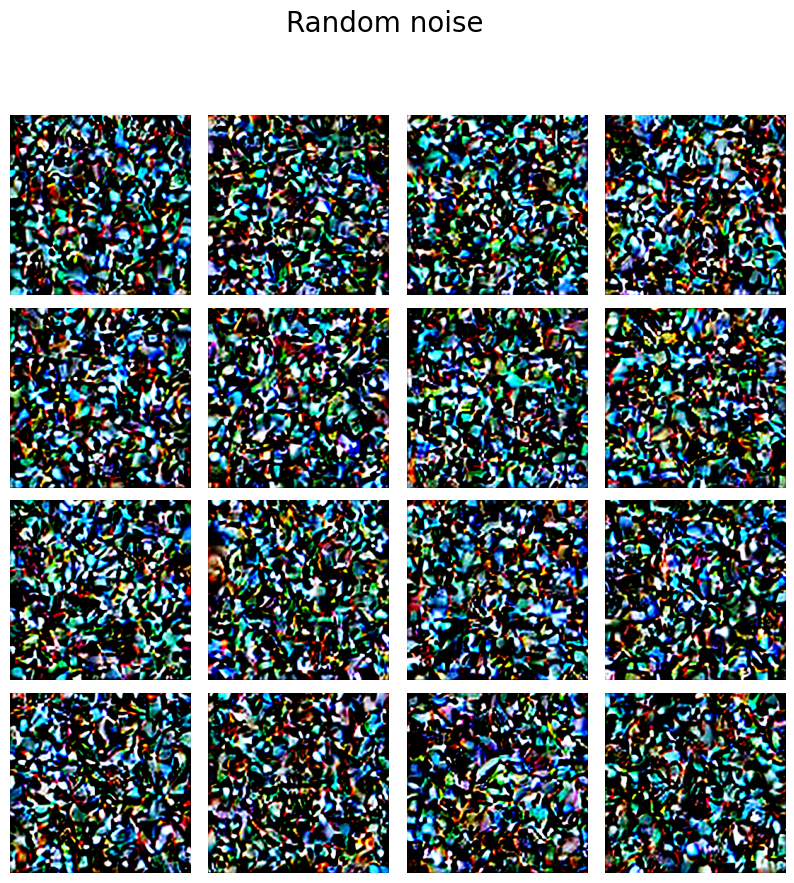

In [7]:
random_noise = torch.randn(16,4,32,32)*5.489
decoded_random_noise = vae.decode(random_noise)['sample']

fig, ax = plt.subplots(4,4,figsize=(10,10),gridspec_kw = {'wspace':0.1, 'hspace':0})
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(decoded_random_noise[i*4+j].clamp(0,1).permute(1,2,0))
        ax[i,j].axis('off')
plt.suptitle('Random noise',fontsize=20)
plt.show()

100%|██████████| 1000/1000 [17:30<00:00,  1.05s/it]


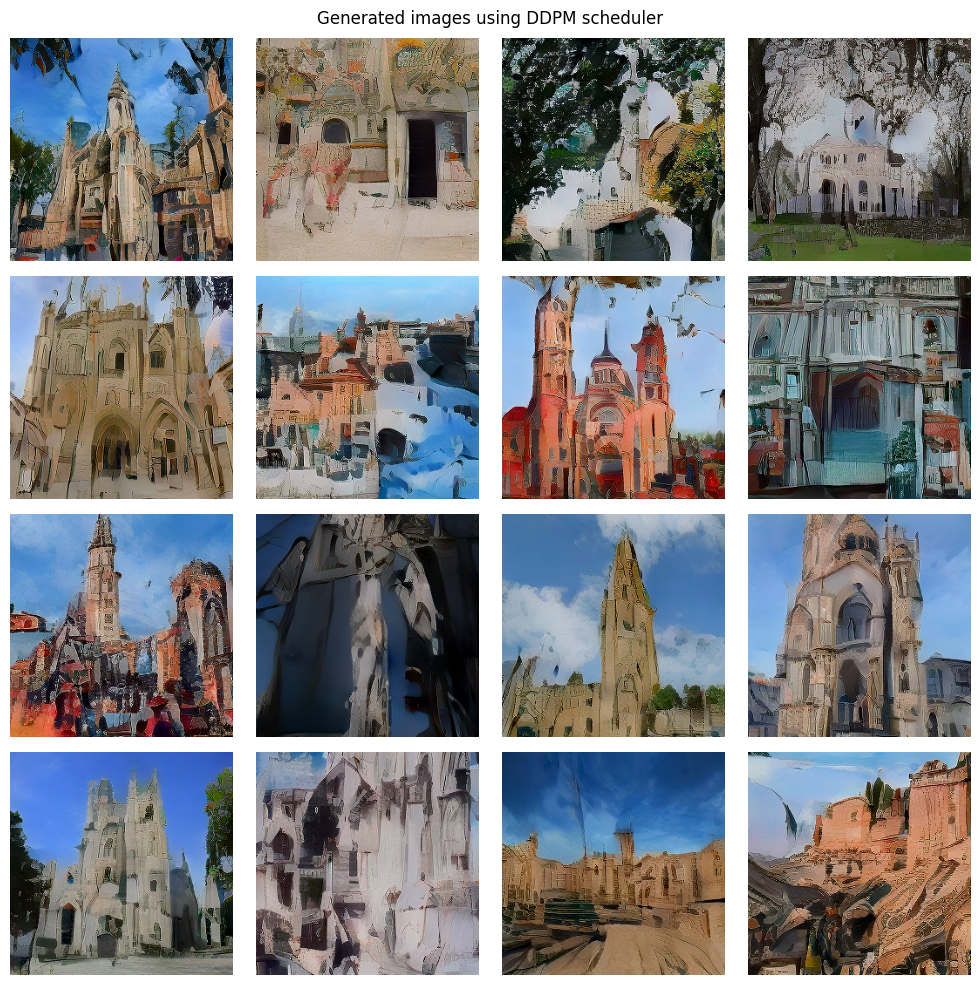

In [25]:
sched = DDPMScheduler(beta_start = 0.00085, beta_end = 0.012)
preds = sample(sched,model)
preds[-1] = preds[-1]*5.489
preds[-1] = vae.decode(preds[-1])['sample']

plt.figure(figsize=(10, 10))
plt.suptitle("Generated images using DDPM scheduler")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((preds[-1][i].permute(1,2,0)).clamp(0,1))
    plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 333/333 [06:15<00:00,  1.13s/it]


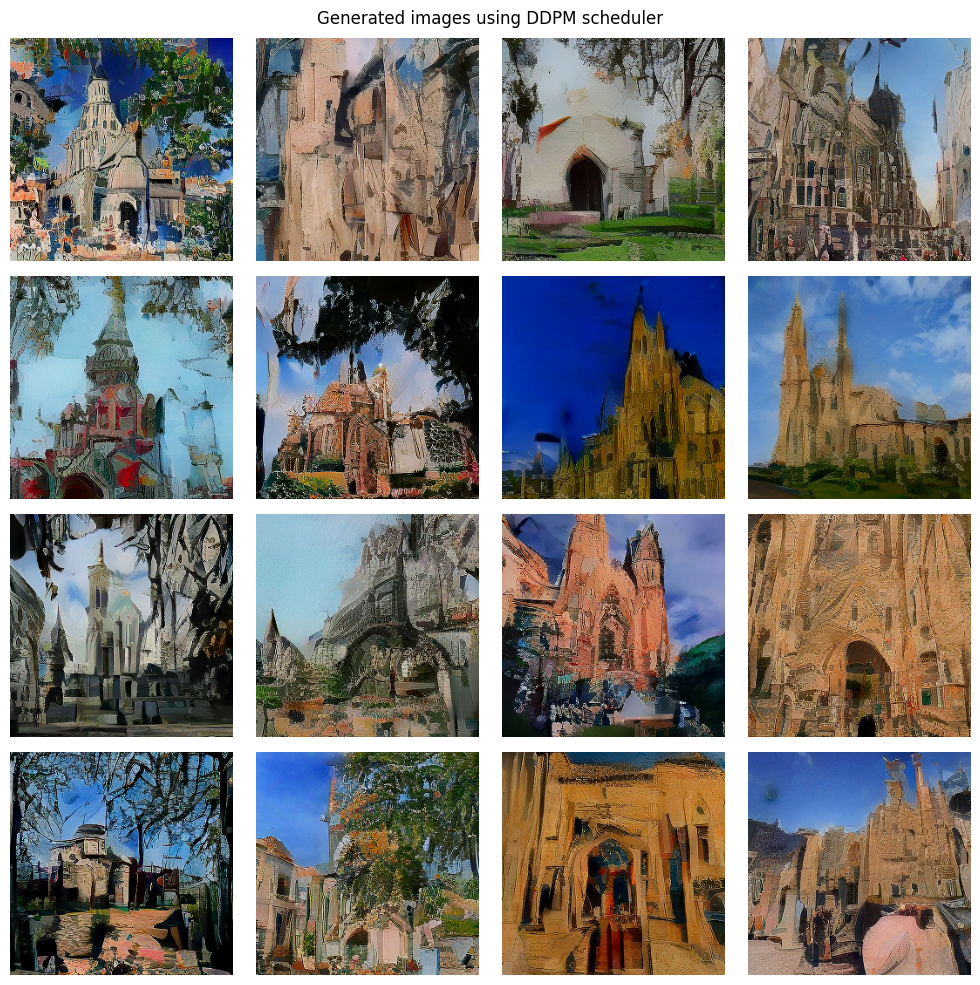

In [26]:
sched = DDIMScheduler(beta_start = 0.00085, beta_end = 0.012)
sched.set_timesteps(333)
preds = sample(sched,model)
preds[-1] = preds[-1]*5.489
preds[-1] = vae.decode(preds[-1])['sample']

plt.figure(figsize=(10, 10))
plt.suptitle("Generated images using DDPM scheduler")
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((preds[-1][i].permute(1,2,0)).clamp(0,1))
    plt.axis('off')
plt.tight_layout()
plt.show()